In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import math

In [2]:
#!/usr/bin/env python
import json
import pandas as pd
import numpy as np

#pd.set_option('display.max_columns', None)
from flatten_json import flatten
from dateutil import parser
from math import sqrt,pow

match_id = '8pm2qt7pp2m2qgnzwrrg8no8a'
filename_event = f'events-ma13-{match_id}.json'
filename_metadata = '2021-08-19-jpl-season-2020-2021-squads.csv'
path = r'C:\Users\fanni\Documents\Egyetem\SzakmaiGyakorlat\StartUp\AdjacencyMatrix\\'

tracking_cols = ['timestamp', 'time_of_current_half', 'half_indicator', 'match_not_in_play',
                 'player_1_teamId', 'player_1_objectId', 'player_1_jerseyNum', 'player_1_x', 'player_1_y',
                 'player_2_teamId', 'player_2_objectId', 'player_2_jerseyNum', 'player_2_x', 'player_2_y',
                 'player_3_teamId', 'player_3_objectId', 'player_3_jerseyNum', 'player_3_x', 'player_3_y',
                 'player_4_teamId', 'player_4_objectId', 'player_4_jerseyNum', 'player_4_x', 'player_4_y',
                 'player_5_teamId', 'player_5_objectId', 'player_5_jerseyNum', 'player_5_x', 'player_5_y',
                 'player_6_teamId', 'player_6_objectId', 'player_6_jerseyNum', 'player_6_x', 'player_6_y',
                 'player_7_teamId', 'player_7_objectId', 'player_7_jerseyNum', 'player_7_x', 'player_7_y',
                 'player_8_teamId', 'player_8_objectId', 'player_8_jerseyNum', 'player_8_x', 'player_8_y',
                 'player_9_teamId', 'player_9_objectId', 'player_9_jerseyNum', 'player_9_x', 'player_9_y',
                 'player_10_teamId', 'player_10_objectId', 'player_10_jerseyNum', 'player_10_x', 'player_10_y',
                 'player_11_teamId', 'player_11_objectId', 'player_11_jerseyNum', 'player_11_x', 'player_11_y',
                 'player_12_teamId', 'player_12_objectId', 'player_12_jerseyNum', 'player_12_x', 'player_12_y',
                 'player_13_teamId', 'player_13_objectId', 'player_13_jerseyNum', 'player_13_x', 'player_13_y',
                 'player_14_teamId', 'player_14_objectId', 'player_14_jerseyNum', 'player_14_x', 'player_14_y',
                 'player_15_teamId', 'player_15_objectId', 'player_15_jerseyNum', 'player_15_x', 'player_15_y',
                 'player_16_teamId', 'player_16_objectId', 'player_16_jerseyNum', 'player_16_x', 'player_16_y',
                 'player_17_teamId', 'player_17_objectId', 'player_17_jerseyNum', 'player_17_x', 'player_17_y',
                 'player_18_teamId', 'player_18_objectId', 'player_18_jerseyNum', 'player_18_x', 'player_18_y',
                 'player_19_teamId', 'player_19_objectId', 'player_19_jerseyNum', 'player_19_x', 'player_19_y',
                 'player_20_teamId', 'player_20_objectId', 'player_20_jerseyNum', 'player_20_x', 'player_20_y',
                 'player_21_teamId', 'player_21_objectId', 'player_21_jerseyNum', 'player_21_x', 'player_21_y',
                 'player_22_teamId', 'player_22_objectId', 'player_22_jerseyNum', 'player_22_x', 'player_22_y',
                 'to_del_1',
                 'ball_x', 'ball_y', 'ball_z',
                 'to_del_2']
filename = f'tracking-data-{match_id}-25fps.txt'
tracking = pd.read_csv(path + filename, sep=";|,|:", names=tracking_cols, header=None, engine='python')
tracking = tracking.drop(labels=['to_del_1', 'to_del_2'], axis=1)

temp = tracking[tracking['half_indicator'] == 1]['time_of_current_half'].max()
tracking['timeMilliSec'] = tracking['time_of_current_half'] + temp * (tracking['half_indicator'] - 1)


with open(path + filename_event) as f:
    d = json.load(f)


def jsonNormalize(data):
    dic_flattened = (flatten(dd) for dd in data)
    df = pd.DataFrame(dic_flattened)
    return df


df1 = jsonNormalize(d['liveData']['event'])
interesting_periods = [1, 2, 3, 4, 5]
interesting_event_ids = [1, 2, 3, 7, 8, 10, 11, 13, 14, 15, 16, 74]
df2 = df1[df1['typeId'].apply(lambda x: x == 32)]
df1 = df1[df1['periodId'].apply(lambda x: x in interesting_periods)]
df1 = df1[df1['typeId'].apply(lambda x: x in interesting_event_ids)]

id_mapping = pd.read_csv(path + filename_metadata)
id_mapping = id_mapping[['matchName', 'stats_id']]
id_mapping.columns = ['playerName', 'playerTrackingId']


def get_tr_id(playerNames):
    ids = []
    for playerName in playerNames:
        id = int(id_mapping[id_mapping['playerName'] == playerName]['playerTrackingId'].values[0])
        ids.append(id)
    return ids


df1['playerTrackingId'] = get_tr_id(df1['playerName'].values)

# Calculate remaining time from half
# Need to group by period because extra time may differ

df1['to_sec'] = df1['timeMin'] * 60 + df1['timeSec']
df1['sec_remaining'] = df1.groupby('periodId').to_sec.transform('max') - df1.to_sec

temp = df1.iloc[0]['timeStamp'].replace('Z', '-01')
temp2 = df1[(df1['periodId'] == 2) & (df1['to_sec'] == 45 * 60)]['timeStamp'].values[0].replace('Z', '-01')
OFFSET_1 = tracking.iloc[0]['timestamp'] - parser.parse(temp).timestamp() * 1000
OFFSET_2 = tracking[(tracking['half_indicator'] == 2) & (tracking['time_of_current_half'] == 0)]['timestamp'].values[
               0] - parser.parse(temp2).timestamp() * 1000


# syncs the tracking and event timestamps for better matching later
def getmillisecs(timestamps, half):
    out = []
    for timestamp in timestamps:
        timestamp = timestamp.replace('Z', '-01')
        if half == 1:
            yourdate = parser.parse(timestamp).timestamp() * 1000 + OFFSET_1
        else:
            yourdate = parser.parse(timestamp).timestamp() * 1000 + OFFSET_2
        out.append(yourdate)
    return out


firsthalf = df1.loc[df1['periodId'] == 1]['timeStamp'].values.tolist()
secondhalf = df1.loc[df1['periodId'] == 2]['timeStamp'].values.tolist()
first = getmillisecs(firsthalf, 1)
second = getmillisecs(secondhalf, 2)
timestamps = first + second
df1['timeStamp'] = timestamps

matchinfo = jsonNormalize(d['matchInfo']['contestant'])

home_team_id = ''

if matchinfo.loc[0,'position'] == 'home':
    df1.loc[df1.contestantId == matchinfo.loc[0,'id'],'event_team'] = 0
    home_team_id = matchinfo.loc[0,'id']
    df1.loc[df1.contestantId == matchinfo.loc[1,'id'],'event_team'] = 1
else:
    df1.loc[df1.contestantId == matchinfo.loc[0,'id'],'event_team'] = 1
    df1.loc[df1.contestantId == matchinfo.loc[1,'id'],'event_team'] = 0
    home_team_id = matchinfo.loc[1,'id']
    
df1['home_attack_dir'] = df2.loc[df2.contestantId == home_team_id,'qualifier_0_value'].values[0]


half1_team1_attackdir = df2['qualifier_0_value'].iloc[0]  # 'Right to Left' or 'Left to Right'

df1['Pass_end_x'] = np.nan
df1['Pass_end_y'] = np.nan
q_ids=[]
q_vals=[]
for column in df1:
    if column.startswith('qualifier') and column.endswith('qualifierId'):
        q_ids.append(column.split('_')[1])
    elif column.startswith('qualifier') and column.endswith('value'):
        q_vals.append(column.split('_')[1])
qs=list(set(q_ids).intersection(q_vals))

if (half1_team1_attackdir == 'Right to Left'):
    df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['x']] = 100 - df1['x']
    df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['x']] = 100 - df1['x']
    df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['y']] = 100 - df1['y']
    df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['y']] = 100 - df1['y']
    # transform the pass destination too
    # count qualifiers

    # X:
    for colnum in qs:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
        # Y:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

elif (half1_team1_attackdir == 'Left to Right'):
    df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['x']] = 100 - df1['x']
    df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['x']] = 100 - df1['x']
    df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['y']] = 100 - df1['y']
    df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['y']] = 100 - df1['y']

    # transform the pass destination too
    # X:
    for colnum in qs:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &  # here
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
        # Y:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

# Pass_end_x and Pass_end_y now only contains the values that need to be flipped, so:
df1['Pass_end_x'] = pd.to_numeric(df1.Pass_end_x, errors='coerce')
df1['Pass_end_y'] = pd.to_numeric(df1.Pass_end_y, errors='coerce')

df1['Pass_end_x'] = 100 - df1['Pass_end_x']
df1['Pass_end_y'] = 100 - df1['Pass_end_y']

# Now add the ones that will not need flipping.
if (half1_team1_attackdir == 'Right to Left'):

    # X: (do we need typeId too??)
    for colnum in qs:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
        # Y:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

elif (half1_team1_attackdir == 'Left to Right'):
    # X:
    for colnum in qs:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
        # Y:
        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

        df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

df1['Pass_end_x'] = pd.to_numeric(df1.Pass_end_x, errors='coerce')
df1['Pass_end_y'] = pd.to_numeric(df1.Pass_end_y, errors='coerce')
# Now scale from 100x100 to 105x68


df1['x'] = df1['x'] * 1.05
df1['y'] = df1['y'] * 0.68
df1['Pass_end_x'] = df1['Pass_end_x'] * 1.05
df1['Pass_end_y'] = df1['Pass_end_y'] * 0.68

# tracking flip y
tracking['ball_y'] = 68 - tracking['ball_y']
for num in range(1, 23):
    tracking[f'player_{num}_y'] = 68 - tracking[f'player_{num}_y']

# calculating velocity (speed and direction) - for players
dT = tracking.loc[1,'timestamp']-tracking.loc[0,'timestamp']
MAXSPEED = 12
MOVING_WINDOW =7
#ma_window = np.ones( MOVING_WINDOW ) / MOVING_WINDOW 

for p_num in range(1,23):
    # directions
    Vx = tracking[f'player_{p_num}_x'].diff() / dT
    Vy = tracking[f'player_{p_num}_y'].diff() / dT

    # get rid of outliers
    if MAXSPEED > 0:
        raw_speed = np.sqrt((Vx**2)+(Vy**2))
        Vx[ raw_speed>MAXSPEED ] = np.nan
        Vy[ raw_speed>MAXSPEED ] = np.nan

    # smoothing
    # calculate first half velocity
    #Vx = np.convolve( Vx , ma_window, mode='same' ) 
    #Vy = np.convolve( Vy , ma_window, mode='same' )      
    Vx = Vx.rolling(MOVING_WINDOW,min_periods = 0,center=False).mean()
    Vy = Vy.rolling(MOVING_WINDOW,min_periods = 0,center=False).mean()

    # apply speed and direction values
    tracking[f'player_{p_num}_direction_x'] = Vx
    tracking[f'player_{p_num}_direction_y'] = Vy
    tracking[f'player_{p_num}_speed'] = np.sqrt((Vx**2)+(Vy**2))
    tracking.loc[:,[f'player_{p_num}_direction_x',f'player_{p_num}_direction_y',f'player_{p_num}_speed']] =\
         tracking.loc[:,[f'player_{p_num}_direction_x',f'player_{p_num}_direction_y',f'player_{p_num}_speed']].fillna(0)

# calculating velocity (speed and direction) - for ball
Vbx = tracking['ball_x'].diff() / dT
Vby = tracking['ball_y'].diff() / dT
if MAXSPEED > 0:
    raw_speed = np.sqrt(Vbx**2+Vby**2)
    Vbx[ raw_speed>MAXSPEED ] = np.nan
    Vby[ raw_speed>MAXSPEED ] = np.nan
Vbx = Vbx.rolling(MOVING_WINDOW,min_periods = 0, center= False).mean()
Vby = Vby.rolling(MOVING_WINDOW,min_periods = 0, center= False).mean()
tracking['ball_direction_x'] = Vx
tracking['ball_direction_y'] = Vy
tracking['ball_speed'] = np.sqrt((Vx**2)+(Vy**2))

tracking.loc[:,['ball_direction_x','ball_direction_y','ball_speed']] = tracking.loc[:,['ball_direction_x','ball_direction_y','ball_speed']].fillna(0)
# Features for events

# For goaldifference; (matchinfo is created to get contestant_id)
homeId = matchinfo['id'].iloc[0]
awayId = matchinfo['id'].iloc[1]

goaldiff_df = pd.DataFrame(None)
goaldiff_df['typeId'] = df1['typeId']
goaldiff_df['contestantId'] = df1['contestantId']
goaldiff_df['is_home_goal'] = np.where((goaldiff_df['typeId'] != 16) | (goaldiff_df['contestantId'] != homeId), 0, 1)
goaldiff_df['is_away_goal'] = np.where((goaldiff_df['typeId'] != 16) | (goaldiff_df['contestantId'] != awayId), 0, 1)
goaldiff_df['Curr_home_goals'] = goaldiff_df['is_home_goal'].cumsum()
goaldiff_df['Curr_away_goals'] = goaldiff_df['is_away_goal'].cumsum()
goaldiff_df['Goal_difference_home'] = goaldiff_df['Curr_home_goals'] - goaldiff_df['Curr_away_goals']
goaldiff_df['Goal_difference_away'] = goaldiff_df['Goal_difference_home'] * -1

df1['Goal_difference_home'] = goaldiff_df['Goal_difference_home']
df1['Goal_difference_away'] = df1['Goal_difference_home'] * -1

tracking.to_csv(path + f'flat-tracking-{match_id}-25fps.csv', index=False)

df1.to_csv(path + f'events-ma13-with-features-{match_id}.csv', index=False)

In [3]:
#TRACKING DATA NEEDS TO BE CLEANED FIRST - done
from inspect import FrameInfo
from math import sqrt
from statistics import mean
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

#opening files
match_id='8pm2qt7pp2m2qgnzwrrg8no8a'
path = r'C:\Users\fanni\Documents\Egyetem\SzakmaiGyakorlat\StartUp\AdjacencyMatrix\\'
tracking_fn=f'flat-tracking-{match_id}-25fps.csv'
event_fn=f'events-ma13-with-features-{match_id}.csv'
tracking_df = pd.read_csv(path+tracking_fn)
event_df = pd.read_csv(path+event_fn)

home_attack_dir=event_df.loc[0,'home_attack_dir']

#helper functions for calculating disance between timestamps
def distance_time(time_from, time_to):
    return abs(time_to - time_from)
def conv_milisec_to_sec(milliseconds):
    return round((milliseconds)/1000)
def conv_min_sec_to_sec(minute,second):
    return (minute*60+second)
#helper functions for calculating distance between positions
def distance_pos(x_1,y_1,x_2,y_2):
    return sqrt((x_2-x_1)**2+(y_2-y_1)**2)


def get_player_pos(playerId,frame):
    x=0
    y=0
    values =frame.values.tolist()
    for elem in values:
        i=values.index(elem)
        if elem == playerId:
            x=frame[i+2]
            y=frame[i+3]
    return x,y

#calculate distance metric for an event and trackinf frame pair
def calc_distance(event,frame,justTime):
    if not justTime:
        #calc time distance
        ev_time = event['timeStamp']
        fr_time = frame['timestamp']
        time_dist = distance_time(ev_time,fr_time)
        #calc positional distance
        #   -ball
        pos_distance_ball = distance_pos(event['x'],event['y'],frame['ball_x'],frame['ball_y'])
        #   -player performing the event
        player = event['playerTrackingId']
        player_x,player_y = get_player_pos(player,frame)
        pos_distance_player = distance_pos(event['x'],event['y'],player_x,player_y)
        #return overall distance
        dist=time_dist*0.33+pos_distance_ball*0.33+pos_distance_player*0.33
    else:
        #calc time distance
        ev_time = event['timeStamp']
        fr_time = frame['timestamp']
        dist = distance_time(ev_time,fr_time)
    return (dist)

#evaluates the syncing - with the difference between tracking player position and event position
def eval(event_df,tracking_df):
    distances=[]
    distances_ball=[]
    distances_x=[]
    distances_y=[]
    for ev_i,event in event_df.iterrows():
        frame = tracking_df.iloc[event['frame_id']]
        player_x, player_y = get_player_pos(event['playerTrackingId'],frame)
        distance = distance_pos(event['x'],event['y'],player_x,player_y)
        distances_ball.append(distance_pos(event['x'],event['y'],frame['ball_x'],frame['ball_y']))
        distances_x.append(abs(event['x']-player_x))
        distances_y.append(abs(event['y']-player_y))
        distances.append(distance)
    return distances,distances_ball,distances_x,distances_y

#match events until distance gets lower, stop when it doesn't
def match_events(event_df,tracking_df,justTime):
    frame_ids=[]
    distances=[]
    tr_i=0
    for ev_i, ev_elem in event_df.iterrows():
        min_dist=calc_distance(ev_elem,tracking_df.iloc[tr_i],justTime)
        dist = calc_distance(ev_elem,tracking_df.iloc[tr_i+1],justTime)
        while (dist<=min_dist):
            tr_i+=1
            min_dist=calc_distance(ev_elem,tracking_df.iloc[tr_i],justTime)
            dist = calc_distance(ev_elem,tracking_df.iloc[tr_i+1],justTime)
        frame_ids.append(tr_i)
        distances.append(min_dist)
    return frame_ids,distances

#look at the next 1500 tracking records and choose the one with the smallest distance
def match_events_2(event_df,tracking_df,justTime):
    frame_ids=[]
    distances=[]
    tr_i=0
    for ev_i, ev_elem in event_df.iterrows():
        fr_dist=[]
        end_i = min(len(tracking_df.index),tr_i+1500)
        for i in range(tr_i,end_i):
            fr_dist.append(calc_distance(ev_elem,tracking_df.iloc[i],justTime))    
        min_dist=min(fr_dist)
        tr_i=tr_i+fr_dist.index(min_dist)
        frame_ids.append(tr_i)
        distances.append(min_dist)
    return frame_ids,distances

def match_events_3(event_df,tracking_df):
    frame_ids=[]
    for ev_i, event in event_df.iterrows():
        rounded_time = int(40* round(float(event['timeStamp'])/40))
        fr_id_l = tracking_df.index[tracking_df['timestamp']==rounded_time].tolist()
        if fr_id_l:
            frame_ids.append(fr_id_l[0])
        else:
            print("error")
    return frame_ids


#frame_ids,distances=match_events(event_df,tracking_df,True)
#frame_ids2,distances2=match_events(event_df,tracking_df,False)
frame_ids3=match_events_3(event_df,tracking_df)
#frame_ids4,distances4=match_events_2(event_df,tracking_df,False)


#event_df2=event_df.copy()
event_df3=event_df.copy()
#event_df4=event_df.copy()


#event_df['frame_id']=frame_ids
#event_df['distance']=distances
#event_df2['frame_id']=frame_ids2
#event_df2['distance']=distances2
event_df3['frame_id']=frame_ids3
#event_df4['frame_id']=frame_ids4
#event_df4['distance']=distances4


#dist,dist_b,dist_x,dist_y=eval(event_df,tracking_df)
#dist2,dist_b2,dist_x2,dist_y2=eval(event_df2,tracking_df)
dist3,dist_b3,dist_x3,dist_y3=eval(event_df3,tracking_df)
event_df3['distance']=dist3
print(event_df3['distance'].max())
event_df3 = event_df3[event_df3['distance']<15]
print(event_df3['distance'].max())

#print(f"Player distance : {dist}, ball distance: {dist_b}, x distance: {dist_x}, y distance: {dist_y}")
#print(f"Player distance : {dist2}, ball distance: {dist_b2}, x distance: {dist_x2}, y distance: {dist_y2}")
print(f"Player distance : {mean(dist3)}, ball distance: {mean(dist_b3)}, x distance: {mean(dist_x3)}, y distance: {mean(dist_y3)}")

#print(eval(event_df3,tracking_df))
#print(eval(event_df4,tracking_df))

#print(event_df.head(1))
#print(tracking_df.iloc[event_df.head(1)['frame_id']])
tracking_df['frame_id'] = tracking_df.index

tracking_w_events =pd.merge(tracking_df,event_df3,how='outer',on=['frame_id'],suffixes=('_tracking','_event'))



tracking_w_events.to_csv(path+f'tracking_w_events_{match_id}.csv',index=False)
synced_events = tracking_w_events[pd.notna(tracking_w_events['eventId'])].copy()

GOAL_X = 100
GOAL_Y = 50
GOALPOST_1Y = 55.3           #was 53.66
GOALPOST_2Y = 44.7           #was 46.34
DIST_GOALPOSTS = 10.6        #a;  was 7.22

def calc_angle_and_distance_to_goal(X,Y, needs_flipping):
    if needs_flipping:
        X = 105-X
    X = X/1.05
    Y = Y/0.68
    diff_X = abs(GOAL_X - X)
    diff_Y = abs(GOAL_Y - Y) 
    dist_to_goal = np.sqrt(diff_X ** 2 + diff_Y ** 2)
    
    diff_gp1y = abs(GOALPOST_1Y - Y)
    diff_gp2y = abs(GOALPOST_2Y - Y)
    dist_gp1y = np.sqrt(diff_X ** 2 + diff_gp1y ** 2) #b
    dist_gp2y = np.sqrt(diff_X ** 2 + diff_gp2y ** 2) #c
    ang_to_goal = np.arccos((dist_gp1y**2 + dist_gp2y**2 - DIST_GOALPOSTS**2)/(2*dist_gp1y*dist_gp2y))
    
    return dist_to_goal, ang_to_goal


for ev_idx, event in synced_events.iterrows():
    ball_carrier = event['playerTrackingId']
    bc_x,bc_y = get_player_pos(ball_carrier,event)
    
    for num in range(1,23):
        p_x,p_y = event[f'player_{num}_x'],event[f'player_{num}_y']
        dist = distance_pos(bc_x,bc_y,p_x,p_y)
        if dist != 0:
            synced_events.loc[ev_idx,f'player_{num}_dist_to_bc'] = dist
            synced_events.loc[ev_idx,f'player_{num}_is_bc'] = 0
        else:
            synced_events.loc[ev_idx,f'player_{num}_dist_to_bc'] = dist
            synced_events.loc[ev_idx,f'player_{num}_is_bc'] = 1
            synced_events.loc[ev_idx,'event_team'] = event[f'player_{num}_teamId']
    
    # ball
    ball_x, ball_y = event['ball_x'],event['ball_y']
    dist_b = distance_pos(bc_x,bc_y,ball_x,ball_y)
    synced_events.loc[ev_idx,'ball_dist_to_bc'] = dist_b
    synced_events.loc[ev_idx,'ball_is_bc'] = 0
    
# ball and player distance- and angle to goal 
second_half_idx = synced_events.half_indicator.idxmax()

if home_attack_dir == 'Left to Right':
     # away_players - calc_angle_and_distance_to_goal(away player X, away player Y, False)
    for num in range(11,21):
        a_p_X_fh = synced_events.loc[:second_half_idx,f'player_{num}_x']
        a_p_Y_fh = synced_events.loc[:second_half_idx,f'player_{num}_y']
        a_p_X_sh = synced_events.loc[second_half_idx:,f'player_{num}_x']
        a_p_Y_sh = synced_events.loc[second_half_idx:,f'player_{num}_y']

        synced_events.loc[:second_half_idx,f'player_{num}_dist_to_goal'],\
            synced_events.loc[:second_half_idx,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(a_p_X_fh,a_p_Y_fh,True)
        synced_events.loc[second_half_idx:,f'player_{num}_dist_to_goal'],\
                synced_events.loc[second_half_idx:,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(a_p_X_sh,a_p_Y_sh,False)
    # away goalkeeper
    a_gk_X_fh = synced_events.loc[:second_half_idx,'player_22_x']
    a_gk_Y_fh = synced_events.loc[:second_half_idx,'player_22_y']
    a_gk_X_sh = synced_events.loc[second_half_idx:,'player_22_x']
    a_gk_Y_sh = synced_events.loc[second_half_idx:,'player_22_y']
    synced_events.loc[:second_half_idx,'player_22_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'player_22_angel_to_goal']=calc_angle_and_distance_to_goal(a_gk_X_fh,a_gk_Y_fh,True)
    synced_events.loc[second_half_idx:,'player_22_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'player_22_angel_to_goal']=calc_angle_and_distance_to_goal(a_gk_X_sh,a_gk_Y_sh,False)
    # home players
    for num in range(1,11):
        h_p_X_fh = synced_events.loc[:second_half_idx,f'player_{num}_x']
        h_p_Y_fh = synced_events.loc[:second_half_idx,f'player_{num}_y']
        h_p_X_sh = synced_events.loc[second_half_idx:,f'player_{num}_x']
        h_p_Y_sh = synced_events.loc[second_half_idx:,f'player_{num}_y']

        synced_events.loc[:second_half_idx,f'player_{num}_dist_to_goal'],\
            synced_events.loc[:second_half_idx,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(h_p_X_fh,h_p_Y_fh,False)
        synced_events.loc[second_half_idx:,f'player_{num}_dist_to_goal'],\
            synced_events.loc[second_half_idx:,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(h_p_X_sh,h_p_Y_sh,True)
    #hom
    #home goalkeeper - calc_angle_and_distance_to_goal(home player X, home player Y, True)
    h_gk_X_fh = synced_events.loc[:second_half_idx,'player_21_x']
    h_gk_Y_fh = synced_events.loc[:second_half_idx,'player_21_y']
    h_gk_X_sh = synced_events.loc[second_half_idx:,'player_21_x']
    h_gk_Y_sh = synced_events.loc[second_half_idx:,'player_21_y']
    synced_events.loc[:second_half_idx,'player_21_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'player_21_angel_to_goal']=calc_angle_and_distance_to_goal(h_gk_X_fh,h_gk_Y_fh,False)
    synced_events.loc[second_half_idx:,'player_21_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'player_21_angel_to_goal']=calc_angle_and_distance_to_goal(h_gk_X_sh,h_gk_Y_sh,True)

    # ball
    b_X_fh = synced_events.loc[:second_half_idx,'ball_x']
    b_Y_fh = synced_events.loc[:second_half_idx,'ball_y']
    b_X_sh = synced_events.loc[second_half_idx:,'ball_x']
    b_Y_sh = synced_events.loc[second_half_idx:,'ball_y']

    if event['event_team'] == 0:
        synced_events.loc[:second_half_idx,'ball_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_fh,b_Y_fh,False)
        synced_events.loc[second_half_idx:,'ball_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_sh,b_Y_sh,True)
        #calc_angle_and_distance_to_goal(ball X, ball Y, True)
    else:
        synced_events.loc[:second_half_idx,'ball_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_fh,b_Y_fh,True)
        synced_events.loc[second_half_idx:,'ball_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_sh,b_Y_sh,False)
        #calc_angle_and_distance_to_goal(ball X, ball Y, False)
    
elif home_attack_dir == 'Right to Left':
     # away_players - calc_angle_and_distance_to_goal(away player X, away player Y, False)
    for num in range(11,21):
        a_p_X_fh = synced_events.loc[:second_half_idx,f'player_{num}_x']
        a_p_Y_fh = synced_events.loc[:second_half_idx,f'player_{num}_y']
        a_p_X_sh = synced_events.loc[second_half_idx:,f'player_{num}_x']
        a_p_Y_sh = synced_events.loc[second_half_idx:,f'player_{num}_y']

        synced_events.loc[:second_half_idx,f'player_{num}_dist_to_goal'],\
            synced_events.loc[:second_half_idx,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(a_p_X_fh,a_p_Y_fh,False)
        synced_events.loc[second_half_idx:,f'player_{num}_dist_to_goal'],\
                synced_events.loc[second_half_idx:,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(a_p_X_sh,a_p_Y_sh,True)
    # away goalkeeper
    a_gk_X_fh = synced_events.loc[:second_half_idx,'player_22_x']
    a_gk_Y_fh = synced_events.loc[:second_half_idx,'player_22_y']
    a_gk_X_sh = synced_events.loc[second_half_idx:,'player_22_x']
    a_gk_Y_sh = synced_events.loc[second_half_idx:,'player_22_y']
    synced_events.loc[:second_half_idx,'player_22_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'player_22_angel_to_goal']=calc_angle_and_distance_to_goal(a_gk_X_fh,a_gk_Y_fh,False)
    synced_events.loc[second_half_idx:,'player_22_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'player_22_angel_to_goal']=calc_angle_and_distance_to_goal(a_gk_X_sh,a_gk_Y_sh,True)
    # home players
    for num in range(1,11):
        h_p_X_fh = synced_events.loc[:second_half_idx,f'player_{num}_x']
        h_p_Y_fh = synced_events.loc[:second_half_idx,f'player_{num}_y']
        h_p_X_sh = synced_events.loc[second_half_idx:,f'player_{num}_x']
        h_p_Y_sh = synced_events.loc[second_half_idx:,f'player_{num}_y']

        synced_events.loc[:second_half_idx,f'player_{num}_dist_to_goal'],\
            synced_events.loc[:second_half_idx,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(h_p_X_fh,h_p_Y_fh,True)
        synced_events.loc[second_half_idx:,f'player_{num}_dist_to_goal'],\
            synced_events.loc[second_half_idx:,f'player_{num}_angel_to_goal']=calc_angle_and_distance_to_goal(h_p_X_sh,h_p_Y_sh,False)
    #home goalkeeper - calc_angle_and_distance_to_goal(home player X, home player Y, True)
    h_gk_X_fh = synced_events.loc[:second_half_idx,'player_21_x']
    h_gk_Y_fh = synced_events.loc[:second_half_idx,'player_21_y']
    h_gk_X_sh = synced_events.loc[second_half_idx:,'player_21_x']
    h_gk_Y_sh = synced_events.loc[second_half_idx:,'player_21_y']
    synced_events.loc[:second_half_idx,'player_21_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'player_21_angel_to_goal']=calc_angle_and_distance_to_goal(h_gk_X_fh,h_gk_Y_fh,True)
    synced_events.loc[second_half_idx:,'player_21_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'player_21_angel_to_goal']=calc_angle_and_distance_to_goal(h_gk_X_sh,h_gk_Y_sh,False)

    # ball
    b_X_fh = synced_events.loc[:second_half_idx,'ball_x']
    b_Y_fh = synced_events.loc[:second_half_idx,'ball_y']
    b_X_sh = synced_events.loc[second_half_idx:,'ball_x']
    b_Y_sh = synced_events.loc[second_half_idx:,'ball_y']

    if event['event_team'] == 0:
        synced_events.loc[:second_half_idx,'ball_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_fh,b_Y_fh,True)
        synced_events.loc[second_half_idx:,'ball_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_sh,b_Y_sh,False)
        #calc_angle_and_distance_to_goal(ball X, ball Y, True)
    else:
        synced_events.loc[:second_half_idx,'ball_dist_to_goal'],\
            synced_events.loc[:second_half_idx,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_fh,b_Y_fh,False)
        synced_events.loc[second_half_idx:,'ball_dist_to_goal'],\
            synced_events.loc[second_half_idx:,'ball_angel_to_goal']=calc_angle_and_distance_to_goal(b_X_sh,b_Y_sh,True)
        #calc_angle_and_distance_to_goal(ball X, ball Y, False)
    
synced_events.to_csv(path+f'events_w_tracking_{match_id}.csv',index=False)

#print(tracking_w_events.distance.mean())
#print(mean(distances2))

63.588650952823336
12.676080032880828
Player distance : 3.944869246688375, ball distance: 4.143689656661427, x distance: 2.736937739463601, y distance: 2.25172509578544


In [4]:
readIn = pd.read_csv("events_w_tracking_8pm2qt7pp2m2qgnzwrrg8no8a.csv")
df1 = pd.DataFrame(readIn)
df1.head(10)

,timestamp,time_of_current_half,half_indicator,match_not_in_play,player_1_teamId,player_1_objectId,player_1_jerseyNum,player_1_x,player_1_y,player_2_teamId,player_2_objectId,player_2_jerseyNum,player_2_x,player_2_y,player_3_teamId,player_3_objectId,player_3_jerseyNum,player_3_x,player_3_y,player_4_teamId,player_4_objectId,player_4_jerseyNum,player_4_x,player_4_y,player_5_teamId,player_5_objectId,player_5_jerseyNum,player_5_x,player_5_y,player_6_teamId,player_6_objectId,player_6_jerseyNum,player_6_x,player_6_y,player_7_teamId,player_7_objectId,player_7_jerseyNum,player_7_x,player_7_y,player_8_teamId,player_8_objectId,player_8_jerseyNum,player_8_x,player_8_y,player_9_teamId,player_9_objectId,player_9_jerseyNum,player_9_x,player_9_y,player_10_teamId,player_10_objectId,player_10_jerseyNum,player_10_x,player_10_y,player_11_teamId,player_11_objectId,player_11_jerseyNum,player_11_x,player_11_y,player_12_teamId,player_12_objectId,player_12_jerseyNum,player_12_x,player_12_y,player_13_teamId,player_13_objectId,player_13_jerseyNum,player_13_x,player_13_y,player_14_teamId,player_14_objectId,player_14_jerseyNum,player_14_x,player_14_y,player_15_teamId,player_15_objectId,player_15_jerseyNum,player_15_x,player_15_y,player_16_teamId,player_16_objectId,player_16_jerseyNum,player_16_x,player_16_y,player_17_teamId,player_17_objectId,player_17_jerseyNum,player_17_x,player_17_y,player_18_teamId,player_18_objectId,player_18_jerseyNum,player_18_x,player_18_y,player_19_teamId,player_19_objectId,player_19_jerseyNum,player_19_x,player_19_y,player_20_teamId,player_20_objectId,player_20_jerseyNum,player_20_x,player_20_y,player_21_teamId,player_21_objectId,player_21_jerseyNum,player_21_x,player_21_y,player_22_teamId,player_22_objectId,player_22_jerseyNum,player_22_x,player_22_y,ball_x,ball_y,ball_z,timeMilliSec,player_1_direction_x,player_1_direction_y,player_1_speed,player_2_direction_x,player_2_direction_y,player_2_speed,player_3_direction_x,player_3_direction_y,player_3_speed,player_4_direction_x,player_4_direction_y,player_4_speed,player_5_direction_x,player_5_direction_y,player_5_speed,player_6_direction_x,player_6_direction_y,player_6_speed,player_7_direction_x,player_7_direction_y,player_7_speed,player_8_direction_x,player_8_direction_y,player_8_speed,player_9_direction_x,player_9_direction_y,player_9_speed,player_10_direction_x,player_10_direction_y,player_10_speed,player_11_direction_x,player_11_direction_y,player_11_speed,player_12_direction_x,player_12_direction_y,player_12_speed,player_13_direction_x,player_13_direction_y,player_13_speed,player_14_direction_x,player_14_direction_y,player_14_speed,player_15_direction_x,player_15_direction_y,player_15_speed,player_16_direction_x,player_16_direction_y,player_16_speed,player_17_direction_x,player_17_direction_y,player_17_speed,player_18_direction_x,player_18_direction_y,player_18_speed,player_19_direction_x,player_19_direction_y,player_19_speed,player_20_direction_x,player_20_direction_y,player_20_speed,player_21_direction_x,player_21_direction_y,player_21_speed,player_22_direction_x,player_22_direction_y,player_22_speed,ball_direction_x,ball_direction_y,ball_speed,frame_id,id,eventId,typeId,periodId,timeMin,timeSec,contestantId,outcome,x,y,timeStamp,lastModified,qualifier_0_id,qualifier_0_qualifierId,qualifier_0_value,qualifier_1_id,qualifier_1_qualifierId,qualifier_1_value,qualifier_2_id,qualifier_2_qualifierId,qualifier_2_value,qualifier_3_id,qualifier_3_qualifierId,qualifier_3_value,qualifier_4_id,qualifier_4_qualifierId,qualifier_4_value,qualifier_5_id,qualifier_5_qualifierId,qualifier_5_value,qualifier_6_id,qualifier_6_qualifierId,qualifier_6_value,qualifier_7_id,qualifier_7_qualifierId,qualifier_7_value,playerId,playerName,sequenceId,possessionId,qualifier_8_id,qualifier_8_qualifierId,qualifier_8_value,qualifier_9_id,qualifier_9_qualifierId,qualifier_10_id,qualifier_10_qualifierId,qualifier_11_id,qualifier_11_qualifierId,qualifier_12_id,qualifier_12_qualifierId,keyPass,qualifier_9_value,qua

In [5]:
print(df1['Pass_end_x'].isna().value_counts(normalize=True))
print(df1['Pass_end_y'].isna().value_counts(normalize=True))

False    0.881844
True     0.118156
Name: Pass_end_x, dtype: float64
False    0.881844
True     0.118156
Name: Pass_end_y, dtype: float64


In [6]:
df_pr = df1[['timestamp', 'Pass_end_x', 'Pass_end_y', 'player_1_x', 'player_1_y', 'player_2_x', 'player_2_y', 'player_3_x', 'player_3_y', 'player_4_x', 'player_4_y', 'player_5_x', 'player_5_y', 'player_6_x', 'player_6_y', 'player_7_x', 'player_7_y', 'player_8_x', 'player_8_y', 'player_9_x', 'player_9_y', 'player_10_x', 'player_10_y', 'player_11_x', 'player_11_y', 'player_12_x', 'player_12_y', 'player_13_x', 'player_13_y', 'player_14_x', 'player_14_y', 'player_15_x', 'player_15_y', 'player_16_x', 'player_16_y', 'player_17_x', 'player_17_y', 'player_18_x', 'player_18_y', 'player_19_x', 'player_19_y', 'player_20_x', 'player_20_y', 'player_21_x', 'player_21_y', 'player_22_x', 'player_22_y']]

In [7]:
df_pr['Pass_end_x'] = df_pr['Pass_end_x'].fillna(0.0)
df_pr['Pass_end_y'] = df_pr['Pass_end_y'].fillna(0.0)
df_pr['closestPlayer'] = 'tbd' 
df_pr.head(3)

<ipython-input-7-4571271e7892>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr['Pass_end_x'] = df_pr['Pass_end_x'].fillna(0.0)
<ipython-input-7-4571271e7892>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr['Pass_end_y'] = df_pr['Pass_end_y'].fillna(0.0)
<ipython-input-7-4571271e7892>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,timestamp,Pass_end_x,Pass_end_y,player_1_x,player_1_y,player_2_x,player_2_y,player_3_x,player_3_y,player_4_x,player_4_y,player_5_x,player_5_y,player_6_x,player_6_y,player_7_x,player_7_y,player_8_x,player_8_y,player_9_x,player_9_y,player_10_x,player_10_y,player_11_x,player_11_y,player_12_x,player_12_y,player_13_x,player_13_y,player_14_x,player_14_y,player_15_x,player_15_y,player_16_x,player_16_y,player_17_x,player_17_y,player_18_x,player_18_y,player_19_x,player_19_y,player_20_x,player_20_y,player_21_x,player_21_y,player_22_x,player_22_y,closestPlayer
0,1618170300000,36.960,36.312,73.662,37.017,71.057,58.949,64.404,33.888,64.224,33.844,57.683,50.663,66.209,47.268,62.236,13.515,78.175,45.493,53.960,25.734,72.800,25.964,40.913,23.519,51.211,23.229,52.636,35.883,46.126,30.051,53.199,53.248,41.628,38.497,43.109,49.299,50.017,65.675,53.052,4.563,52.170,42.621,99.751,35.691,3.522,35.925,tbd
1,1618170302880,40.950,47.192,73.700,37.743,73.715,58.328,64.604,38.105,57.770,35.093,62.713,54.588,71.225,50.106,67.974,13.313,80.671,46.693,47.145,36.211,74.627,24.897,44.258,17.668,59.985,23.195,60.889,37.848,48.387,32.188,71.569,54.281,41.929,40.009,44.739,52.405,57.324,66.000,62.028,4.301,57.154,42.565,95.345,34.868,7.619,35.535,tbd
2,1618170305880,69.195,2.720,74.577,40.482,69.857,62.371,64.112,46.809,59.360,41.094,56.909,56.703,64.069,53.229,65.944,26.056,74.246,49.761,51.541,45.674,75.745,30.064,48.936,28.041,70.151,31.405,71.153,38.765,53.754,39.026,72.952,54.377,37.548,41.529,47.720,55.350,64.099,69.214,72.782,10.907,59.309,48.909,94.379,35.836,11.736,36.985,tbd


In [8]:
minValue = 1000.0
minValues = []

for row in df_pr.index:
    if((df_pr.at[row,'Pass_end_x']) and (df_pr.at[row,'Pass_end_x']) != 0.0): # checks if its an event or just tracking
        locationX = df_pr.at[row,'Pass_end_x']
        locationY = df_pr.at[row,'Pass_end_y']
        p = [locationX, locationY] # creates a point from the end coordinates
        for col in range(0,22,2):
            qX = df_pr.iloc[row,3+col]
            qY = df_pr.iloc[row,3+col+1]
            q = [qX, qY]
            value = math.dist(p,q) 
            if(value < minValue):
                minValue = value
                df_pr.at[row,'closestPlayer'] = str(df_pr.iloc[[row],[3+col]])
        minValues.append(minValue)
        minValue = 1000.0

In [9]:
print(df_pr.iloc[0,46])
print(df_pr.iloc[72,46])

35.925
33.51


In [10]:
df_pr['closestPlayer'] = df_pr['closestPlayer'].astype(str)

<ipython-input-10-95dfa4b3aae7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr['closestPlayer'] = df_pr['closestPlayer'].astype(str)


In [11]:
for row in df_pr.index:
    if(df_pr.at[row, 'closestPlayer'] != 'tbd'):
        tmp = df_pr.at[row, 'closestPlayer']
        partitioned_string = tmp.partition('x')
        #print(partitioned_string)
        playerNum = partitioned_string[0]
        playerNum = playerNum.replace('_','')
        playerNum = playerNum.replace(' ','')
        df_pr.at[row, 'closestPlayer'] = playerNum
        #print(playerNum)

In [12]:
df_pr.head(5)

,timestamp,Pass_end_x,Pass_end_y,player_1_x,player_1_y,player_2_x,player_2_y,player_3_x,player_3_y,player_4_x,player_4_y,player_5_x,player_5_y,player_6_x,player_6_y,player_7_x,player_7_y,player_8_x,player_8_y,player_9_x,player_9_y,player_10_x,player_10_y,player_11_x,player_11_y,player_12_x,player_12_y,player_13_x,player_13_y,player_14_x,player_14_y,player_15_x,player_15_y,player_16_x,player_16_y,player_17_x,player_17_y,player_18_x,player_18_y,player_19_x,player_19_y,player_20_x,player_20_y,player_21_x,player_21_y,player_22_x,player_22_y,closestPlayer
0,1618170300000,36.960,36.312,73.662,37.017,71.057,58.949,64.404,33.888,64.224,33.844,57.683,50.663,66.209,47.268,62.236,13.515,78.175,45.493,53.960,25.734,72.800,25.964,40.913,23.519,51.211,23.229,52.636,35.883,46.126,30.051,53.199,53.248,41.628,38.497,43.109,49.299,50.017,65.675,53.052,4.563,52.170,42.621,99.751,35.691,3.522,35.925,player11
1,1618170302880,40.950,47.192,73.700,37.743,73.715,58.328,64.604,38.105,57.770,35.093,62.713,54.588,71.225,50.106,67.974,13.313,80.671,46.693,47.145,36.211,74.627,24.897,44.258,17.668,59.985,23.195,60.889,37.848,48.387,32.188,71.569,54.281,41.929,40.009,44.739,52.405,57.324,66.000,62.028,4.301,57.154,42.565,95.345,34.868,7.619,35.535,player9
2,1618170305880,69.195,2.720,74.577,40.482,69.857,62.371,64.112,46.809,59.360,41.094,56.909,56.703,64.069,53.229,65.944,26.056,74.246,49.761,51.541,45.674,75.745,30.064,48.936,28.041,70.151,31.405,71.153,38.765,53.754,39.026,72.952,54.377,37.548,41.529,47.720,55.350,64.099,69.214,72.782,10.907,59.309,48.909,94.379,35.836,11.736,36.985,player7
3,1618170309320,61.110,5.440,84.253,29.516,77.311,49.885,72.815,33.134,67.683,26.865,60.109,47.424,69.584,39.977,72.706,10.884,81.597,42.339,55.806,35.186,81.920,21.604,56.488,13.771,79.766,21.612,82.562,26.762,64.331,24.242,78.953,46.446,45.945,33.300,48.544,51.001,65.273,56.831,71.134,3.512,64.952,40.357,98.305,32.321,15.318,35.413,player11
4,1618170311520,103.635,10.540,81.397,17.488,81.605,42.628,76.588,21.888,70.409,12.229,63.765,41.802,68.807,29.886,66.744,3.021,82.964,35.963,56.501,25.525,76.038,9.088,61.630,4.152,74.230,8.633,80.308,15.711,67.872,15.036,81.402,40.186,47.860,23.039,50.654,44.821,65.397,50.804,70.200,-0.545,64.419,29.367,98.053,31.642,18.008,33.388,player1


In [13]:
df_pr['closestPlayer'].value_counts()

tbd         123
player9     107
player5      99
player7      95
player11     92
player10     83
player6      82
player2      81
player4      81
player1      77
player3      71
player8      50
Name: closestPlayer, dtype: int64

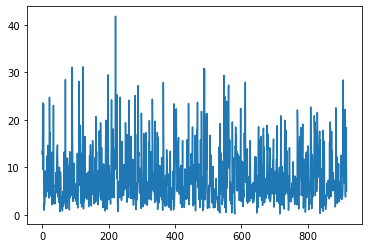

In [14]:
plt.plot(minValues)
plt.show()

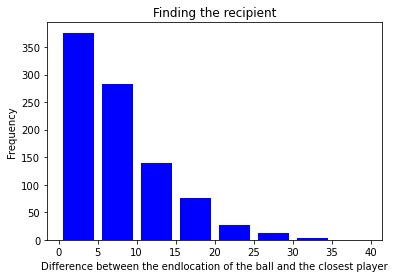

In [15]:
range = (0, 40)
bins =  8
  
# plotting a histogram
plt.hist(minValues, bins, range, color = 'blue',
        histtype = 'bar', rwidth = 0.8)

# x-axis label
plt.xlabel('Difference between the endlocation of the ball and the closest player')
# frequency label
plt.ylabel('Frequency')
# plot title
plt.title('Finding the recipient')

plt.show()

In [17]:
df1 = pd.merge(df1, df_pr, on='timestamp', how='left')

In [18]:
df1['typeId'].value_counts()

1.0     916
3.0      25
7.0      20
74.0     18
8.0      17
13.0     16
15.0     11
10.0     11
16.0      3
11.0      2
2.0       2
Name: typeId, dtype: int64

In [19]:
df1['closestPlayer'] = df1['closestPlayer'].astype(str)
type(df1['closestPlayer'])

pandas.core.series.Series

In [20]:
for row in df1.index:
    if (df1.at[row, 'closestPlayer'] != 'tbd'):
        tmp = str(df1.at[row, 'closestPlayer'])
        tmp = tmp.replace('player','')
        df1.at[row, 'closestPlayer'] = tmp
df1.head(1)

,timestamp,time_of_current_half,half_indicator,match_not_in_play,player_1_teamId,player_1_objectId,player_1_jerseyNum,player_1_x_x,player_1_y_x,player_2_teamId,player_2_objectId,player_2_jerseyNum,player_2_x_x,player_2_y_x,player_3_teamId,player_3_objectId,player_3_jerseyNum,player_3_x_x,player_3_y_x,player_4_teamId,player_4_objectId,player_4_jerseyNum,player_4_x_x,player_4_y_x,player_5_teamId,player_5_objectId,player_5_jerseyNum,player_5_x_x,player_5_y_x,player_6_teamId,player_6_objectId,player_6_jerseyNum,player_6_x_x,player_6_y_x,player_7_teamId,player_7_objectId,player_7_jerseyNum,player_7_x_x,player_7_y_x,player_8_teamId,player_8_objectId,player_8_jerseyNum,player_8_x_x,player_8_y_x,player_9_teamId,player_9_objectId,player_9_jerseyNum,player_9_x_x,player_9_y_x,player_10_teamId,player_10_objectId,player_10_jerseyNum,player_10_x_x,player_10_y_x,player_11_teamId,player_11_objectId,player_11_jerseyNum,player_11_x_x,player_11_y_x,player_12_teamId,player_12_objectId,player_12_jerseyNum,player_12_x_x,player_12_y_x,player_13_teamId,player_13_objectId,player_13_jerseyNum,player_13_x_x,player_13_y_x,player_14_teamId,player_14_objectId,player_14_jerseyNum,player_14_x_x,player_14_y_x,player_15_teamId,player_15_objectId,player_15_jerseyNum,player_15_x_x,player_15_y_x,player_16_teamId,player_16_objectId,player_16_jerseyNum,player_16_x_x,player_16_y_x,player_17_teamId,player_17_objectId,player_17_jerseyNum,player_17_x_x,player_17_y_x,player_18_teamId,player_18_objectId,player_18_jerseyNum,player_18_x_x,player_18_y_x,player_19_teamId,player_19_objectId,player_19_jerseyNum,player_19_x_x,player_19_y_x,player_20_teamId,player_20_objectId,player_20_jerseyNum,player_20_x_x,player_20_y_x,player_21_teamId,player_21_objectId,player_21_jerseyNum,player_21_x_x,player_21_y_x,player_22_teamId,player_22_objectId,player_22_jerseyNum,player_22_x_x,player_22_y_x,ball_x,ball_y,ball_z,timeMilliSec,player_1_direction_x,player_1_direction_y,player_1_speed,player_2_direction_x,player_2_direction_y,player_2_speed,player_3_direction_x,player_3_direction_y,player_3_speed,player_4_direction_x,player_4_direction_y,player_4_speed,player_5_direction_x,player_5_direction_y,player_5_speed,player_6_direction_x,player_6_direction_y,player_6_speed,player_7_direction_x,player_7_direction_y,player_7_speed,player_8_direction_x,player_8_direction_y,player_8_speed,player_9_direction_x,player_9_direction_y,player_9_speed,player_10_direction_x,player_10_direction_y,player_10_speed,player_11_direction_x,player_11_direction_y,player_11_speed,player_12_direction_x,player_12_direction_y,player_12_speed,player_13_direction_x,player_13_direction_y,player_13_speed,player_14_direction_x,player_14_direction_y,player_14_speed,player_15_direction_x,player_15_direction_y,player_15_speed,player_16_direction_x,player_16_direction_y,player_16_speed,player_17_direction_x,player_17_direction_y,player_17_speed,player_18_direction_x,player_18_direction_y,player_18_speed,player_19_direction_x,player_19_direction_y,player_19_speed,player_20_direction_x,player_20_direction_y,player_20_speed,player_21_direction_x,player_21_direction_y,player_21_speed,player_22_direction_x,player_22_direction_y,player_22_speed,ball_direction_x,ball_direction_y,ball_speed,frame_id,id,eventId,typeId,periodId,timeMin,timeSec,contestantId,outcome,x,y,timeStamp,lastModified,qualifier_0_id,qualifier_0_qualifierId,qualifier_0_value,qualifier_1_id,qualifier_1_qualifierId,qualifier_1_value,qualifier_2_id,qualifier_2_qualifierId,qualifier_2_value,qualifier_3_id,qualifier_3_qualifierId,qualifier_3_value,qualifier_4_id,qualifier_4_qualifierId,qualifier_4_value,qualifier_5_id,qualifier_5_qualifierId,qualifier_5_value,qualifier_6_id,qualifier_6_qualifierId,qualifier_6_value,qualifier_7_id,qualifier_7_qualifierId,qualifier_7_value,playerId,playerName,sequenceId,possessionId,qualifier_8_id,qualifier_8_qualifierId,qualifier_8_value,qualifier_9_id,qualifier_9_qualifierId,qualifier_10_id,qualifier_10_qualifierId,qualifier_11_id,qualifi

In [ ]:
err

In [21]:
df1['recipientId'] = 0

for row in df1.index:
    if (df1.at[row, 'closestPlayer'] != 'tbd'):
        num = int(df1.at[row, 'closestPlayer'])
        #print(df1.iloc[row, num*5])
        df1.at[row, 'recipientId'] = int(df1.iloc[row, num*5])

In [22]:
df1.head(3)

,timestamp,time_of_current_half,half_indicator,match_not_in_play,player_1_teamId,player_1_objectId,player_1_jerseyNum,player_1_x_x,player_1_y_x,player_2_teamId,player_2_objectId,player_2_jerseyNum,player_2_x_x,player_2_y_x,player_3_teamId,player_3_objectId,player_3_jerseyNum,player_3_x_x,player_3_y_x,player_4_teamId,player_4_objectId,player_4_jerseyNum,player_4_x_x,player_4_y_x,player_5_teamId,player_5_objectId,player_5_jerseyNum,player_5_x_x,player_5_y_x,player_6_teamId,player_6_objectId,player_6_jerseyNum,player_6_x_x,player_6_y_x,player_7_teamId,player_7_objectId,player_7_jerseyNum,player_7_x_x,player_7_y_x,player_8_teamId,player_8_objectId,player_8_jerseyNum,player_8_x_x,player_8_y_x,player_9_teamId,player_9_objectId,player_9_jerseyNum,player_9_x_x,player_9_y_x,player_10_teamId,player_10_objectId,player_10_jerseyNum,player_10_x_x,player_10_y_x,player_11_teamId,player_11_objectId,player_11_jerseyNum,player_11_x_x,player_11_y_x,player_12_teamId,player_12_objectId,player_12_jerseyNum,player_12_x_x,player_12_y_x,player_13_teamId,player_13_objectId,player_13_jerseyNum,player_13_x_x,player_13_y_x,player_14_teamId,player_14_objectId,player_14_jerseyNum,player_14_x_x,player_14_y_x,player_15_teamId,player_15_objectId,player_15_jerseyNum,player_15_x_x,player_15_y_x,player_16_teamId,player_16_objectId,player_16_jerseyNum,player_16_x_x,player_16_y_x,player_17_teamId,player_17_objectId,player_17_jerseyNum,player_17_x_x,player_17_y_x,player_18_teamId,player_18_objectId,player_18_jerseyNum,player_18_x_x,player_18_y_x,player_19_teamId,player_19_objectId,player_19_jerseyNum,player_19_x_x,player_19_y_x,player_20_teamId,player_20_objectId,player_20_jerseyNum,player_20_x_x,player_20_y_x,player_21_teamId,player_21_objectId,player_21_jerseyNum,player_21_x_x,player_21_y_x,player_22_teamId,player_22_objectId,player_22_jerseyNum,player_22_x_x,player_22_y_x,ball_x,ball_y,ball_z,timeMilliSec,player_1_direction_x,player_1_direction_y,player_1_speed,player_2_direction_x,player_2_direction_y,player_2_speed,player_3_direction_x,player_3_direction_y,player_3_speed,player_4_direction_x,player_4_direction_y,player_4_speed,player_5_direction_x,player_5_direction_y,player_5_speed,player_6_direction_x,player_6_direction_y,player_6_speed,player_7_direction_x,player_7_direction_y,player_7_speed,player_8_direction_x,player_8_direction_y,player_8_speed,player_9_direction_x,player_9_direction_y,player_9_speed,player_10_direction_x,player_10_direction_y,player_10_speed,player_11_direction_x,player_11_direction_y,player_11_speed,player_12_direction_x,player_12_direction_y,player_12_speed,player_13_direction_x,player_13_direction_y,player_13_speed,player_14_direction_x,player_14_direction_y,player_14_speed,player_15_direction_x,player_15_direction_y,player_15_speed,player_16_direction_x,player_16_direction_y,player_16_speed,player_17_direction_x,player_17_direction_y,player_17_speed,player_18_direction_x,player_18_direction_y,player_18_speed,player_19_direction_x,player_19_direction_y,player_19_speed,player_20_direction_x,player_20_direction_y,player_20_speed,player_21_direction_x,player_21_direction_y,player_21_speed,player_22_direction_x,player_22_direction_y,player_22_speed,ball_direction_x,ball_direction_y,ball_speed,frame_id,id,eventId,typeId,periodId,timeMin,timeSec,contestantId,outcome,x,y,timeStamp,lastModified,qualifier_0_id,qualifier_0_qualifierId,qualifier_0_value,qualifier_1_id,qualifier_1_qualifierId,qualifier_1_value,qualifier_2_id,qualifier_2_qualifierId,qualifier_2_value,qualifier_3_id,qualifier_3_qualifierId,qualifier_3_value,qualifier_4_id,qualifier_4_qualifierId,qualifier_4_value,qualifier_5_id,qualifier_5_qualifierId,qualifier_5_value,qualifier_6_id,qualifier_6_qualifierId,qualifier_6_value,qualifier_7_id,qualifier_7_qualifierId,qualifier_7_value,playerId,playerName,sequenceId,possessionId,qualifier_8_id,qualifier_8_qualifierId,qualifier_8_value,qualifier_9_id,qualifier_9_qualifierId,qualifier_10_id,qualifier_10_qualifierId,qualifier_11_id,qualifi

In [27]:
print(df1.columns.get_loc('player_1_dist_to_bc'))
print(df1.columns.get_loc('player_2_dist_to_bc'))
print(df1.columns.get_loc('player_21_dist_to_bc'))
print(df1.columns.get_loc('player_22_dist_to_bc'))

284
286
324
326


In [30]:
# coordinates of recipient & player

df1['playerDistance'] = 0.0

for row in df1.index:
    if (df1.at[row, 'closestPlayer'] != 'tbd'):
        num = int(df1.at[row, 'closestPlayer'])
        #print(df1.iloc[row, num*5])
        df1.at[row, 'playerDistance'] = float(df1.iloc[row, (284+(num-1)*2)])
df1.head(4)

,timestamp,time_of_current_half,half_indicator,match_not_in_play,player_1_teamId,player_1_objectId,player_1_jerseyNum,player_1_x_x,player_1_y_x,player_2_teamId,player_2_objectId,player_2_jerseyNum,player_2_x_x,player_2_y_x,player_3_teamId,player_3_objectId,player_3_jerseyNum,player_3_x_x,player_3_y_x,player_4_teamId,player_4_objectId,player_4_jerseyNum,player_4_x_x,player_4_y_x,player_5_teamId,player_5_objectId,player_5_jerseyNum,player_5_x_x,player_5_y_x,player_6_teamId,player_6_objectId,player_6_jerseyNum,player_6_x_x,player_6_y_x,player_7_teamId,player_7_objectId,player_7_jerseyNum,player_7_x_x,player_7_y_x,player_8_teamId,player_8_objectId,player_8_jerseyNum,player_8_x_x,player_8_y_x,player_9_teamId,player_9_objectId,player_9_jerseyNum,player_9_x_x,player_9_y_x,player_10_teamId,player_10_objectId,player_10_jerseyNum,player_10_x_x,player_10_y_x,player_11_teamId,player_11_objectId,player_11_jerseyNum,player_11_x_x,player_11_y_x,player_12_teamId,player_12_objectId,player_12_jerseyNum,player_12_x_x,player_12_y_x,player_13_teamId,player_13_objectId,player_13_jerseyNum,player_13_x_x,player_13_y_x,player_14_teamId,player_14_objectId,player_14_jerseyNum,player_14_x_x,player_14_y_x,player_15_teamId,player_15_objectId,player_15_jerseyNum,player_15_x_x,player_15_y_x,player_16_teamId,player_16_objectId,player_16_jerseyNum,player_16_x_x,player_16_y_x,player_17_teamId,player_17_objectId,player_17_jerseyNum,player_17_x_x,player_17_y_x,player_18_teamId,player_18_objectId,player_18_jerseyNum,player_18_x_x,player_18_y_x,player_19_teamId,player_19_objectId,player_19_jerseyNum,player_19_x_x,player_19_y_x,player_20_teamId,player_20_objectId,player_20_jerseyNum,player_20_x_x,player_20_y_x,player_21_teamId,player_21_objectId,player_21_jerseyNum,player_21_x_x,player_21_y_x,player_22_teamId,player_22_objectId,player_22_jerseyNum,player_22_x_x,player_22_y_x,ball_x,ball_y,ball_z,timeMilliSec,player_1_direction_x,player_1_direction_y,player_1_speed,player_2_direction_x,player_2_direction_y,player_2_speed,player_3_direction_x,player_3_direction_y,player_3_speed,player_4_direction_x,player_4_direction_y,player_4_speed,player_5_direction_x,player_5_direction_y,player_5_speed,player_6_direction_x,player_6_direction_y,player_6_speed,player_7_direction_x,player_7_direction_y,player_7_speed,player_8_direction_x,player_8_direction_y,player_8_speed,player_9_direction_x,player_9_direction_y,player_9_speed,player_10_direction_x,player_10_direction_y,player_10_speed,player_11_direction_x,player_11_direction_y,player_11_speed,player_12_direction_x,player_12_direction_y,player_12_speed,player_13_direction_x,player_13_direction_y,player_13_speed,player_14_direction_x,player_14_direction_y,player_14_speed,player_15_direction_x,player_15_direction_y,player_15_speed,player_16_direction_x,player_16_direction_y,player_16_speed,player_17_direction_x,player_17_direction_y,player_17_speed,player_18_direction_x,player_18_direction_y,player_18_speed,player_19_direction_x,player_19_direction_y,player_19_speed,player_20_direction_x,player_20_direction_y,player_20_speed,player_21_direction_x,player_21_direction_y,player_21_speed,player_22_direction_x,player_22_direction_y,player_22_speed,ball_direction_x,ball_direction_y,ball_speed,frame_id,id,eventId,typeId,periodId,timeMin,timeSec,contestantId,outcome,x,y,timeStamp,lastModified,qualifier_0_id,qualifier_0_qualifierId,qualifier_0_value,qualifier_1_id,qualifier_1_qualifierId,qualifier_1_value,qualifier_2_id,qualifier_2_qualifierId,qualifier_2_value,qualifier_3_id,qualifier_3_qualifierId,qualifier_3_value,qualifier_4_id,qualifier_4_qualifierId,qualifier_4_value,qualifier_5_id,qualifier_5_qualifierId,qualifier_5_value,qualifier_6_id,qualifier_6_qualifierId,qualifier_6_value,qualifier_7_id,qualifier_7_qualifierId,qualifier_7_value,playerId,playerName,sequenceId,possessionId,qualifier_8_id,qualifier_8_qualifierId,qualifier_8_value,qualifier_9_id,qualifier_9_qualifierId,qualifier_10_id,qualifier_10_qualifierId,qualifier_11_id,qualifi

In [32]:
#df1['time_step'] = 0

#for row in range(0,len(df1)-1,1):
#    df1.at[row, 'time_step'] = int(df1.at[row+1, 'timestamp']) - int(df1.at[row, 'timestamp'])

In [36]:
df_adj = df1[['playerTrackingId', 'recipientId', 'outcome', 'timestamp', 'typeId', 'contestantId', 'playerDistance']]
df_adj.dropna(subset=['playerTrackingId'], how='all', inplace=True)
df_adj.head(4)

<ipython-input-36-922a7bb6e833>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adj.dropna(subset=['playerTrackingId'], how='all', inplace=True)


,playerTrackingId,recipientId,outcome,timestamp,typeId,contestantId,playerDistance
0,743228.0,356560,1.0,1618170300000,1.0,2b57rbw94i9ohnbch52owvqtq,17.038111
1,871279.0,1102488,1.0,1618170302880,1.0,2b57rbw94i9ohnbch52owvqtq,6.452245
2,973617.0,789193,1.0,1618170305880,1.0,2b57rbw94i9ohnbch52owvqtq,34.500038
3,1061321.0,356560,1.0,1618170309320,1.0,2b57rbw94i9ohnbch52owvqtq,17.881622


In [37]:
df_adj['contestantId'].value_counts()

2b57rbw94i9ohnbch52owvqtq    625
cyrrlv6l1onld5x247w1q1jlr    416
Name: contestantId, dtype: int64

In [38]:
for row in df_adj.index:
    if(df_adj.at[row, 'contestantId'] == '2b57rbw94i9ohnbch52owvqtq'):
        df_adj.at[row, 'contestantId'] = 'teamA'        
    else:
        df_adj.at[row, 'contestantId'] = 'teamB' 

In [39]:
df_adj['typeId'] = df_adj['typeId'].values.astype(str)
df_adj.dtypes

<ipython-input-39-7cb52ed6f104>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adj['typeId'] = df_adj['typeId'].values.astype(str)


playerTrackingId    float64
recipientId           int64
outcome             float64
timestamp             int64
typeId               object
contestantId         object
playerDistance      float64
dtype: object

In [40]:
for row in df_adj.index:
    if((df_adj.at[row, 'typeId'] == '1.0') | (df_adj.at[row, 'typeId'] == '2.0')):
        df_adj.at[row, 'typeId'] = 'pass'        
    elif((df_adj.at[row, 'typeId'] == '13.0') | (df_adj.at[row, 'typeId'] == '14.0') | (df_adj.at[row, 'typeId'] == '16.0')):
        df_adj.at[row, 'typeId'] = 'shot'            
    elif(df_adj.at[row, 'typeId'] == '3.0'):
        df_adj.at[row, 'typeId'] = 'dribble'            
    elif(df_adj.at[row, 'typeId'] == '8.0'):
        df_adj.at[row, 'typeId'] = 'interception'            
    elif((df_adj.at[row, 'typeId'] == '7.0') | (df_adj.at[row, 'typeId'] == '74.0')):
        df_adj.at[row, 'typeId'] = 'tackle'           
    elif((df_adj.at[row, 'typeId'] == '10.0') | (df_adj.at[row, 'typeId'] == '11.0') | (df_adj.at[row, 'typeId'] == '15.0')):
        df_adj.at[row, 'typeId'] = 'save'   

In [41]:
df_adj['typeId'].value_counts()

pass            918
tackle           38
dribble          25
save             24
shot             19
interception     17
Name: typeId, dtype: int64

In [42]:
for row in df_adj.index:
    if(df_adj.at[row, 'typeId'] == 'pass'):
        if(df_adj.at[row, 'outcome'] == 0.0):
            df_adj.at[row, 'recipientId'] = 0.0 # to mark that it is unknown/unintended

In [45]:
df_adj['teammates'] = 'tbd'

for row in df_adj.index: # in case of passes, the players are considered teammates, otherwise not
    if(df_adj.at[row, 'typeId'] == 'pass'):
        df_adj.at[row, 'teammates'] = '1'
    else:
         df_adj.at[row, 'teammates'] = '0'
            
df_adj.head(100)

<ipython-input-45-c212dd03c32b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adj['teammates'] = 'tbd'


,playerTrackingId,recipientId,outcome,timestamp,typeId,contestantId,playerDistance,teammates
0,743228.0,356560,1.0,1618170300000,pass,teamA,17.038111,1
1,871279.0,1102488,1.0,1618170302880,pass,teamA,6.452245,1
2,973617.0,789193,1.0,1618170305880,pass,teamA,34.500038,1
3,1061321.0,356560,1.0,1618170309320,pass,teamA,17.881622,1
4,356560.0,354626,1.0,1618170311520,pass,teamA,23.844982,1
...,...,...,...,...,...,...,...,...
95,1061319.0,0,1.0,1618170780400,tackle,teamA,0.000000,0
96,1061319.0,0,0.0,1618170782560,pass,teamA,3.007013,1
97,752504.0,0,0.0,1618170784760,pass,teamA,5.403772,1
98,466925.0,0,0.0,1618170788200,pass,teamB,12.732333,1


In [51]:
from pathlib import Path  
filepath = Path(r'C:\Users\fanni\Documents\Egyetem\SzakmaiGyakorlat\StartUp\AdjacencyMatrix\df_adj.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_adj.to_csv(filepath) 